Best parameters for IsolationForest: {'contamination': 0.03, 'max_samples': 'auto', 'n_estimators': 200}
Classification report for IsolationForest:
              precision    recall  f1-score   support

          -1       0.78      0.78      0.78      6884
           1       0.99      0.99      0.99    222555

    accuracy                           0.99    229439
   macro avg       0.89      0.89      0.89    229439
weighted avg       0.99      0.99      0.99    229439



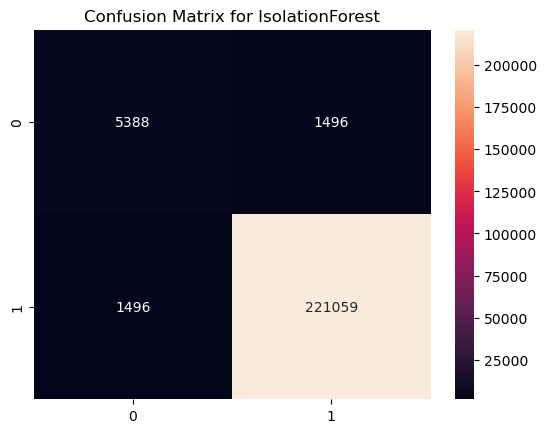

Best parameters for OneClassSVM: {'gamma': 0.1, 'kernel': 'rbf', 'nu': 0.01}
Classification report for OneClassSVM:
              precision    recall  f1-score   support

          -1       0.53      0.18      0.26      6884
           1       0.98      1.00      0.98    222555

    accuracy                           0.97    229439
   macro avg       0.75      0.59      0.62    229439
weighted avg       0.96      0.97      0.96    229439



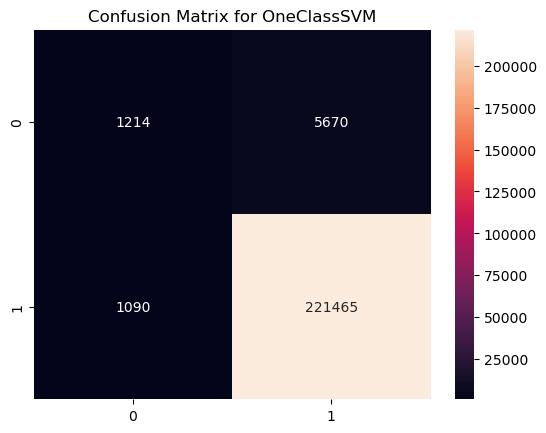

Best parameters for LocalOutlierFactor: {'contamination': 0.01, 'n_neighbors': 20}
Classification report for LocalOutlierFactor:
              precision    recall  f1-score   support

          -1       0.08      0.03      0.04      6884
           1       0.97      0.99      0.98    222555

    accuracy                           0.96    229439
   macro avg       0.53      0.51      0.51    229439
weighted avg       0.94      0.96      0.95    229439



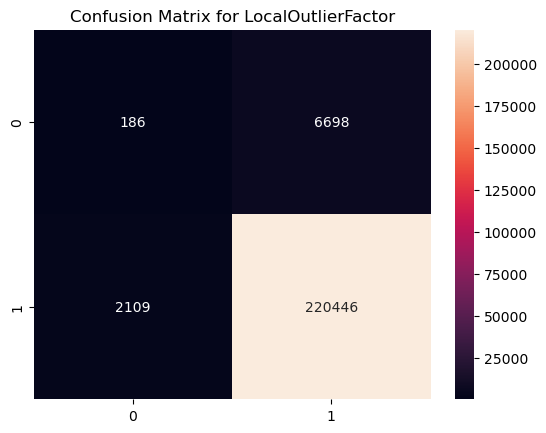

Identified 1502 potentially fraudulent transactions.
Identified 46 high-risk users.
Identified 19 high-risk third-party accounts.


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
file_path = 'data2.csv'
data = pd.read_csv(file_path)

# Data preprocessing
data = data.dropna(subset=['Date', 'Timestamp', 'Account No', 'Amount'])
data = data.dropna(subset=['Third Party Account No', 'Third Party Name'], how='all')

data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month 
data['Day'] = data['Date'].dt.day

data['third_party_type'] = data['Third Party Name'].apply(lambda x: 'Company' if pd.notnull(x) else 'Individual')

transaction_freq = data.groupby('Account No').size().reset_index(name='transaction_count')
data = pd.merge(data, transaction_freq, on='Account No', how='left')

amount_stats = data.groupby('Account No')['Amount'].agg(['mean', 'std', 'max', 'min']).reset_index()
amount_stats.columns = ['Account No', 'avg_amount', 'std_amount', 'max_amount', 'min_amount']
data = pd.merge(data, amount_stats, on='Account No', how='left')

third_party_diversity = data.groupby('Account No')['Third Party Account No'].nunique().reset_index(name='num_third_party')
data = pd.merge(data, third_party_diversity, on='Account No', how='left')

data['hour'] = pd.to_datetime(data['Timestamp'], format='%H:%M').dt.hour
data['is_night_transaction'] = (data['hour'] >= 0) & (data['hour'] < 6)

data['is_integer_amount'] = data['Amount'].apply(lambda x: 'Yes' if x.is_integer() else 'No')

data['weekday'] = pd.to_datetime(data['Date'], format='%d/%m/%Y').dt.weekday.astype(str)

# Add balance feature
data['Balance'] = data['Balance'].fillna(0)  # Replace NaN with 0 if needed

# Add average transaction interval feature
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%H:%M')
data['TransactionInterval'] = data.groupby('Account No')['Timestamp'].diff().dt.total_seconds().fillna(0)
data['AvgTransactionInterval'] = data.groupby('Account No')['TransactionInterval'].transform('mean')

# Feature sets

numeric_features = ['Amount', 'transaction_count', 'avg_amount', 'std_amount', 'max_amount', 'min_amount', 
                                    'num_third_party', 'Balance', 'AvgTransactionInterval']
categorical_features = ['weekday', 'is_night_transaction', 'third_party_type']

# Preprocessing pipelines


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

data_transformed = preprocessor.fit_transform(data[numeric_features + categorical_features])

# Preliminary labeling using Isolation Forest
clf_if = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.03, random_state=42)
clf_if.fit(data_transformed)
y_true = clf_if.predict(data_transformed)

# Hyperparameter tuning and model evaluation
def evaluate_model(model, params, X, y):
    grid_search = GridSearchCV(model, params, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='f1', n_jobs=-1)
    grid_search.fit(X, y)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    best_model = model.__class__(**grid_search.best_params_)
    
    if isinstance(best_model, LocalOutlierFactor):
        y_pred = best_model.fit_predict(X)
    else:
        best_model.fit(X)
        y_pred = best_model.predict(X)
    
    print(f"Classification report for {model.__class__.__name__}:")
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()
    return best_model, y_pred

# Hyperparameter tuning and evaluation for each model
param_grid_if = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 'auto'],
    'contamination': [0.01, 0.03]
}
clf_if, y_pred_if = evaluate_model(IsolationForest(random_state=42), param_grid_if, data_transformed, y_true)

param_grid_svm = {
    'nu': [0.01, 0.03, 0.05],
    'kernel': ['rbf'],
    'gamma': [0.05, 0.1]
}
clf_svm, y_pred_svm = evaluate_model(OneClassSVM(), param_grid_svm, data_transformed, y_true)

param_grid_lof = {
    'n_neighbors': [10, 20, 30],
    'contamination': [0.01, 0.03]
}
clf_lof, y_pred_lof = evaluate_model(LocalOutlierFactor(novelty=True), param_grid_lof, data_transformed, y_true)


# Weighted voting
weights = {'if': 0.4, 'svm': 0.3, 'lof': 0.3}  # Assign weights to each model

y_pred_weighted = weights['if'] * y_pred_if + weights['svm'] * y_pred_svm + \
                                  weights['lof'] * y_pred_lof

y_pred = np.where(y_pred_weighted < 0, -1, 1)

# Identify high-risk users and third-parties
HIGH_RISK_USER_THRESHOLD = 10
HIGH_RISK_THIRD_PARTY_THRESHOLD = 10

fraud_transactions = data[y_pred == -1]

user_fraud_count = fraud_transactions.groupby('Account No').size().reset_index(name='fraud_count')
high_risk_users = user_fraud_count[user_fraud_count['fraud_count'] > HIGH_RISK_USER_THRESHOLD]['Account No']

high_risk_transactions = data[(data['Account No'].isin(high_risk_users)) | (data['Third Party Account No'].isin(high_risk_users))]
third_party_risk = high_risk_transactions.groupby('Third Party Account No').size().reset_index(name='risk_count')
high_risk_third_parties = third_party_risk[third_party_risk['risk_count'] > HIGH_RISK_THIRD_PARTY_THRESHOLD]['Third Party Account No']
high_risk_third_parties = high_risk_third_parties[~high_risk_third_parties.isin(high_risk_users)]

print(f"Identified {len(fraud_transactions)} potentially fraudulent transactions.")
print(f"Identified {len(high_risk_users)} high-risk users.")
print(f"Identified {len(high_risk_third_parties)} high-risk third-party accounts.")